In [655]:
import copy
from dataclasses import dataclass, field
from enum import IntEnum
from typing import TypeVar, Union, Sequence, Optional, Dict, Tuple, Mapping, MutableMapping, MutableSequence, List

import clingo
import clingo.ast
import clingraph
from clingraph.graphviz import compute_graphs
from clingraph.orm import Factbase

In [656]:
ForwardVariable = TypeVar('ForwardVariable', bound='Variable')


@dataclass(frozen=True, order=True)
class Variable:
    name: str

    def __str__(self):
        return self.name

    def as_clingo_ast(self, start_pos: Optional[clingo.ast.Position] = None) -> clingo.ast.AST:
        if start_pos is None:
            start_pos = clingo.ast.Position('<string>', 1, 1)
        end_pos = clingo.ast.Position(start_pos.filename, start_pos.line, start_pos.column + len(self.name))
        loc = clingo.ast.Location(start_pos, end_pos)
        return clingo.ast.Variable(loc, self.name)

    @staticmethod
    def from_clingo_ast(variable: clingo.ast.AST) -> ForwardVariable:
        assert variable.ast_type is clingo.ast.ASTType.Variable, "AST {} should have type {}, but has type {}.".format(
            variable, clingo.ast.ASTType.Variable, variable.ast_type)
        return Variable(variable.name)


ForwardIntegerConstant = TypeVar('ForwardIntegerConstant', bound='IntegerConstant')


@dataclass(frozen=True, order=True)
class IntegerConstant:
    number: int = 0

    def __str__(self):
        return str(self.number)

    def as_clingo_symbol(self):
        return clingo.Number(self.number)

    @staticmethod
    def from_clingo_symbol(symbol: clingo.Symbol):
        assert symbol.type is clingo.SymbolType.Number, "clingo.Symbol {} should have type {}, but has type {}".format(
            symbol, clingo.SymbolType.Number, symbol.type)
        return IntegerConstant(symbol.number)


ForwardTerm = TypeVar('ForwardTerm', bound='Term')


@dataclass(frozen=True, order=True)
class Term:
    constant: IntegerConstant = field(default=IntegerConstant())

    def __str__(self):
        return str(self.constant)

    def as_clingo_ast(self, start_pos: Optional[clingo.ast.Position] = None) -> clingo.ast.AST:
        if start_pos is None:
            start_pos = clingo.ast.Position('<string>', 1, 1)
        end_pos = clingo.ast.Position(start_pos.filename, start_pos.line, start_pos.column + len(str(self)))
        loc = clingo.ast.Location(start_pos, end_pos)
        return clingo.ast.SymbolicTerm(loc, self.constant.as_clingo_symbol())

    @staticmethod
    def from_clingo_ast(term: clingo.ast.AST) -> ForwardTerm:
        assert term.ast_type is clingo.ast.ASTType.SymbolicTerm, "AST {} should have type {}, but has type {}.".format(
            term, clingo.ast.ASTType.SymbolicTerm, term.ast_type)
        symbol: clingo.Symbol = term.symbol
        if symbol.type is clingo.SymbolType.Number:
            return Term(IntegerConstant.from_clingo_symbol(symbol))
        assert False


In [657]:
ForwardAtom = TypeVar('ForwardAtom', bound='Atom')
ForwardFunction = TypeVar('ForwardFunction', bound='Function')


@dataclass
class Function:
    name: Optional[str] = None
    arguments: Sequence[ForwardAtom] = ()

    @property
    def arity(self):
        return len(self.arguments)

    def __str__(self):
        if self.name is None and not self.arguments:
            return "()"
        elif self.name is not None and not self.arguments:
            return self.name
        elif self.name is None and self.arguments:
            return "({})".format(','.join(map(str, self.arguments)))
        else:
            return "{}({})".format(self.name, ','.join(map(str, self.arguments)))

    def match(self, name: Optional[str], arity: int = 0) -> bool:
        return name == self.name and arity == len(self.arguments)

    def match_signature(self, other: ForwardFunction) -> bool:
        return self.match(other.name, other.arity)

    def recursive_rename(self, new_name: Optional[str]) -> ForwardFunction:
        stack: List[Function] = [self]
        while stack:
            current: Function = stack.pop()
            if current.match(self.name, self.arity):
                current.name = new_name
            for arg in current.arguments:
                if arg.is_function():
                    stack.append(arg.symbol)
        return self

In [658]:
@dataclass
class Atom:
    symbol: Union[Variable, Term, Function] = field(default_factory=Function)

    def is_variable(self) -> bool:
        return isinstance(self.symbol, Variable)

    def is_term(self) -> bool:
        return isinstance(self.symbol, Term)

    def is_function(self) -> bool:
        return isinstance(self.symbol, Function)

    def __str__(self):
        return str(self.symbol)

    def fill(self, env: Mapping[Variable, ForwardAtom]) -> ForwardAtom:
        stack: List[Atom] = [self]
        while stack:
            current: Atom = stack.pop()
            if current.is_function():
                arguments = list(current.symbol.arguments)
                i = 0
                while i < current.symbol.arity:
                    arg: Atom = arguments[i]
                    if arg.is_variable() and arg in env:
                        arguments[i] = env[arg.symbol]
                    else:
                        stack.append(arg)
                    i += 1
                assert len(current.symbol.arguments) == len(
                    arguments), "Function.fill should not change arity of Function."
                current.symbol.arguments = arguments
        return self

    @staticmethod
    def new_integer(number: int) -> ForwardAtom:
        return Atom(Term(IntegerConstant(number)))

    @staticmethod
    def new_variable(name: str) -> ForwardAtom:
        return Atom(Variable(name))

    @staticmethod
    def new_function(name: Optional[str], arguments: Sequence[ForwardAtom] = ()) -> ForwardAtom:
        return Atom(Function(name, arguments))

    @staticmethod
    def new_constant(name: Optional[str]) -> ForwardAtom:
        return Atom.new_function(name)

    @staticmethod
    def new_tuple(arguments: Sequence[ForwardAtom]) -> ForwardAtom:
        return Atom.new_function(None, arguments)

    @staticmethod
    def from_clingo_number(num: clingo.Symbol) -> ForwardAtom:
        assert num.type is clingo.SymbolType.Number, "clingo.Symbol {} should have type {} but has type {}.".format(
            num, clingo.SymbolType.Number.name, num.type.name)
        number: int = num.number
        return Atom.new_integer(number)

    @staticmethod
    def from_clingo_function(func: clingo.Symbol) -> ForwardAtom:
        assert func.type is clingo.SymbolType.Function, "clingo.Symbol {} should have type {} but has type {}.".format(
            func, clingo.SymbolType.Function.name, func.type.name)
        name: str = func.name
        arguments: Tuple[ForwardAtom] = tuple(Atom.from_clingo_symbol(argument) for argument in func.arguments)
        return Atom.new_function(name, arguments)

    @staticmethod
    def from_clingo_symbol(symbol: clingo.Symbol) -> ForwardAtom:
        if symbol.type is clingo.SymbolType.Function:
            return Atom.from_clingo_function(symbol)
        elif symbol.type is clingo.SymbolType.Number:
            return Atom.from_clingo_number(symbol)

In [659]:
class Sign(IntEnum):
    NoSign = 0
    DefaultNeg = 1


@dataclass
class Literal:
    atom: Atom = field(default_factory=Atom)
    sign: Sign = Sign.NoSign

    def __str__(self):
        if self.sign is Sign.DefaultNeg:
            return "not {}".format(self.atom)
        return str(self.atom)

    def __abs__(self):
        return Literal(sign=Sign.NoSign, atom=copy.deepcopy(self.atom))

    def __neg__(self):
        return Literal(sign=Sign(self.sign.value ^ 1), atom=copy.deepcopy(self.atom))

In [660]:
ForwardRule = TypeVar('ForwardRule', bound='Rule')


@dataclass
class Rule:
    head: Optional[Literal] = None
    body: MutableSequence[Literal] = ()

    def __str__(self) -> str:
        if self.head is None and not self.body:
            return ":-."
        elif self.head is None:
            return ":- {}.".format(', '.join(map(str, self.body)))
        elif not self.body:
            return "{}.".format(self.head)
        else:
            return "{} :- {}.".format(self.head, ', '.join(map(str, self.body)))

    def is_ground(self) -> bool:
        pass

    def substitute(self, env: Mapping[Variable, Atom]) -> ForwardRule:
        if self.head is not None and self.head.atom.is_function():
            self.head.atom.fill(env)
        for literal in self.body:
            if literal.atom.is_function():
                literal.atom.fill(env)
        return self

    def rename_atoms(self, new_name: Optional[str], name: Optional[str], arity: int = 0, head=True,
                     body=True) -> ForwardRule:
        if head:
            if self.head.atom.is_function() and self.head.atom.symbol.match(name, arity):
                self.head.atom.symbol.recursive_rename(new_name)
        if body:
            for literal in self.body:
                if literal.atom.is_function() and literal.atom.symbol.match(name, arity):
                    literal.atom.symbol.recursive_rename(new_name)
        return self

    def postulate(self) -> ForwardRule:
        self.body.clear()
        return self

    def as_clingo_ast(self) -> clingo.ast.AST:
        pass

In [661]:
ForwardGoal = TypeVar('ForwardGoal', bound='Goal')


@dataclass
class Goal:
    rule: Optional[Rule] = None
    parent: Optional[ForwardGoal] = field(default=None, repr=False)
    children: Sequence[ForwardGoal] = field(default_factory=list, repr=False)
    env: Dict[Variable, Term] = field(default_factory=dict)
    inx: int = field(default=0, repr=False)


ProofTree = Goal

In [662]:
def unify(src_atom: Atom, src_env: Mapping[Variable, Atom], dest_atom: Atom,
          dest_env: Optional[MutableMapping[Variable, Atom]] = None) -> bool:
    src_symbol = src_atom.symbol
    dest_symbol = dest_atom.symbol
    if not isinstance(src_symbol, Function):
        return False
    if not isinstance(dest_symbol, Function):
        return False
    if not src_symbol.match_signature(dest_symbol):
        return False
    if dest_env is None:
        dest_env = {}
    for i in range(src_symbol.arity):
        src_arg: Atom = src_symbol.arguments[i]
        dest_arg: Atom = dest_symbol.arguments[i]
        if isinstance(src_arg.symbol, Variable):
            src_val = src_env.get(src_arg.symbol)
        else:
            src_val = src_arg
        if src_val is not None:
            if isinstance(dest_arg.symbol, Variable):
                dest_val = dest_env.get(dest_arg.symbol)
                if dest_val is None:
                    dest_env[dest_arg.symbol] = src_val
                elif dest_val != src_val:
                    return False
            elif dest_arg != src_val:
                return False
    return True

In [663]:
def search(atom: Atom, rules: Sequence[Rule] = ()) -> Sequence[ProofTree]:
    root = Goal(rule=Rule(head=Literal(), body=[Literal(atom=atom)]))
    proof_trees = []
    stack = [root]
    while stack:
        current = stack.pop()
        if current.inx >= len(current.rule.body):
            if current.parent is None:
                if current.env:
                    print(current.env)
                else:
                    print("Yes")
                proof_trees.append(current)
            else:
                parent = copy.deepcopy(current.parent)
                unify(current.rule.head.atom, current.env, parent.rule.body[parent.inx].atom, parent.env)
                parent.inx += 1
                stack.append(parent)
        else:
            atom = current.rule.body[current.inx].atom
            for rule in rules:
                child_env = {}
                unifiable = unify(atom, current.env, rule.head.atom, child_env)
                if unifiable:
                    child = Goal(env=child_env, parent=current, rule=rule)
                    current.children.append(child)
                    stack.append(child)
    if not proof_trees:
        print("No")
    return proof_trees

In [664]:
@dataclass
class Program:
    rules: MutableSequence[Rule] = field(default_factory=list)

    def __str__(self):
        return ' '.join(map(str, self.rules))

    def query(self, atom):
        prooftrees = search(atom, self.rules)
        envs = [prooftree.env for prooftree in prooftrees]
        return envs

    def evaluate_backwards(self, atom) -> Sequence[Atom]:
        prooftrees = search(atom, self.rules)
        answers = []
        for prooftree in prooftrees:
            stack = [prooftree]
            while stack:
                current = stack.pop()
                env = current.env
                for literal in current.body:
                    fact = Rule(head=literal)
                    fact.substitute(env)
                    if fact.is_ground() and fact not in answers:
                        answers.append(fact)
                stack.extend(current.children)
        return answers


In [665]:
p = Atom.new_constant('p')
q = Atom.new_constant('q')
r = Atom.new_constant('r')

rule1 = Rule(head=Literal(atom=p),
             body=[Literal(atom=q),
                   Literal(sign=Sign.DefaultNeg, atom=r),
                   Literal(sign=Sign.DefaultNeg, atom=p)])
program1 = Program([rule1])
print(program1)

p :- q, not r, not p.


In [666]:
p = Atom.new_constant('p')
q = Atom.new_constant('q')
r = Atom.new_constant('r')

rule2 = Rule(head=Literal(atom=p),
             body=[Literal(atom=q),
                   Literal(sign=Sign.DefaultNeg, atom=p)])
rule3 = Rule(head=Literal(atom=p),
             body=[Literal(sign=Sign.DefaultNeg, atom=r)])
program2 = Program([rule2, rule3])
print(program2)


p :- q, not p. p :- not r.


In [667]:
p = Atom.new_constant('p')
q = Atom.new_constant('q')
r = Atom.new_constant('r')

rule4 = Rule(head=Literal(atom=p),
             body=[
                 Literal(sign=Sign.DefaultNeg, atom=q),
                 Literal(sign=Sign.DefaultNeg, atom=r),
                 Literal(sign=Sign.DefaultNeg, atom=p)
             ])

program3 = Program([rule4])
print(program3)

p :- not q, not r, not p.


In [668]:
q = Atom.new_constant('q')
r = Atom.new_constant('r')

rule5 = Rule(head=None,
             body=[
                 Literal(sign=Sign.DefaultNeg, atom=q),
                 Literal(sign=Sign.DefaultNeg, atom=r),
             ])

program4 = Program([rule5])
print(program4)

:- not q, not r.


In [669]:
a = Atom.new_constant('a')
a_lit = Literal(a)
b = Atom.new_constant('b')
b_lit = Literal(b)
c = Atom.new_constant('c')
c_lit = Literal(c)
e = Atom.new_constant('e')
e_lit = Literal(e)
f = Atom.new_constant('f')
f_lit = Literal(f)
k = Atom.new_constant('k')
k_lit = Literal(k)

rule6 = Rule(head=a_lit, body=[k_lit, -b_lit])
rule7 = Rule(head=k_lit, body=[e_lit, -b_lit])
rule8 = Rule(head=c_lit, body=[a_lit, b_lit])
rule9 = Rule(head=b_lit, body=[-a_lit])
rule10 = Rule(head=c_lit, body=[k_lit])
rule11 = Rule(head=f_lit, body=[e_lit, -k_lit, -c_lit])
rule12 = Rule(head=e_lit)
program5 = Program([rule6, rule7, rule8, rule9, rule10, rule11, rule12])
print(program5)

a :- k, not b. k :- e, not b. c :- a, b. b :- not a. c :- k. f :- e, not k, not c. e.


In [670]:
def cnr_asp(program: Program, graph_name: str = "default") -> Program:
    nodes = []
    edges = []
    rule_count = 0
    g = Atom.new_constant(graph_name)
    graph = Rule(head=Literal(Atom.new_function('graph', [g])))
    for rule in program.rules:
        rule_count += 1
        head = rule.head
        body = rule.body

        if head is None:
            head = Literal(atom=Atom.new_function('__false', [Atom.new_integer(rule_count), g]))
            head_node = Rule(head=Literal(Atom.new_function('node', [head.atom, g])))
            head_graph = head.atom
        else:
            head_graph = Atom.new_function('graph', [head.atom, g])
            head_node = Rule(head=Literal(Atom.new_function('node', [head_graph, g])))

        if head_node not in nodes:
            nodes.append(head_node)
        for literal in body:
            body_node = Rule(head=Literal(Atom.new_function('node', [
                Atom.new_function('graph', [literal.atom, g]),
                g])))
            if body_node not in nodes:
                nodes.append(body_node)
        if len(body) == 1:
            edge = Rule(head=Literal(
                Atom.new_function('edge_sign', [
                    Atom.new_tuple((
                        head_graph, Atom.new_function('graph', [body[0].atom, g]))),
                    Atom.new_integer(body[0].sign.value),
                    g])))
            edges.append(edge)
        elif len(body) > 1:
            conj = Atom.new_function('__conjunction', [Atom.new_integer(rule_count), g])
            conj_node = Rule(head=Literal(
                Atom.new_function('node', [conj, g])
            ))
            nodes.append(conj_node)
            for literal in body:
                body_edge = Rule(head=Literal(
                    Atom.new_function('edge_sign', [
                        Atom.new_tuple([Atom.new_function('graph', [literal.atom, g]), conj]),
                        Atom.new_integer(literal.sign.value ^ 1),
                        g
                    ])
                ))
                edges.append(body_edge)
            head_edge = Rule(head=Literal(
                Atom.new_function('edge_sign', [
                    Atom.new_tuple([conj, head_graph]),
                    Atom.new_integer(Sign.DefaultNeg.value),
                    g
                ])))
            edges.append(head_edge)
    rules = [graph]
    rules.extend(nodes)
    rules.extend(edges)
    return Program(rules)

In [671]:
graph_program1 = cnr_asp(program1, 'program1')
print(graph_program1)
graph_program2 = cnr_asp(program2, 'program2')
print(graph_program2)
graph_program3 = cnr_asp(program3, 'program3')
print(graph_program3)
graph_program4 = cnr_asp(program4, 'program4')
print(graph_program4)
graph_program5 = cnr_asp(program5, 'program5')
print(graph_program5)


graph(program1). node(graph(p,program1),program1). node(graph(q,program1),program1). node(graph(r,program1),program1). node(__conjunction(1,program1),program1). edge_sign((graph(q,program1),__conjunction(1,program1)),1,program1). edge_sign((graph(r,program1),__conjunction(1,program1)),0,program1). edge_sign((graph(p,program1),__conjunction(1,program1)),0,program1). edge_sign((__conjunction(1,program1),graph(p,program1)),1,program1).
graph(program2). node(graph(p,program2),program2). node(graph(q,program2),program2). node(__conjunction(1,program2),program2). node(graph(r,program2),program2). edge_sign((graph(q,program2),__conjunction(1,program2)),1,program2). edge_sign((graph(p,program2),__conjunction(1,program2)),0,program2). edge_sign((__conjunction(1,program2),graph(p,program2)),1,program2). edge_sign((graph(p,program2),graph(r,program2)),1,program2).
graph(program3). node(graph(p,program3),program3). node(graph(q,program3),program3). node(graph(r,program3),program3). node(__conjunct

In [672]:
viz = """

edge(E, G) :- edge_sign(E,S,G).

attr(node, N, label, "C") :- node(N, _G), N=__conjunction(_C, _G).
attr(node, N, style, filled) :- node(N, _G), N=__conjunction(_C, _G).
attr(node, N, color, black) :- node(N, _G), N=__conjunction(_C, _G).
attr(node, N, fontcolor, white) :- node(N, _G), N=__conjunction(_C, _G).
attr(node, N, label, L) :- node(N, G), N=graph(L,G).
attr(node, N, label, false) :- node(N, G), N=__false(_F,G).
attr(node, N, shape, box) :- node(N, G), N=__false(_F,G).

attr(edge, E, dir, forward) :- edge(E,_G).
attr(edge, E, label, "+") :- edge(E,_G), edge_sign(E, 0, _G).
attr(edge, E, label, "-") :- edge(E,_G), edge_sign(E, 1, _G).


"""

In [673]:
ctl = clingo.Control()
ctl.configuration.solve.models = 0
ctl.add('base', [], str(graph_program1))
ctl.add('base', [], str(graph_program2))
ctl.add('base', [], str(graph_program3))
ctl.add('base', [], str(graph_program4))
ctl.add('base', [], str(graph_program5))
ctl.add('viz', [], viz)
ctl.ground([('base', ())])
ctl.ground([('viz', ())], context=clingraph.clingo_utils.ClingraphContext)
fb = Factbase()

In [674]:
with ctl.solve(yield_=True) as solve_handle:
    models = []
    for model in solve_handle:
        symbols = sorted(model.symbols(shown=True))
        print("Answer {}:".format(model.number), end=' ')
        print("{",
              '\n'.join(map(str, symbols)), "}", sep='\n')
        models.append(symbols)
    solve_result = solve_handle.get()
    fb.add_model(model)
    print(solve_result, end='')
    if models:
        print(" {}{}".format(len(models), '' if solve_result.exhausted else '+'))

Answer 1: {
graph(program1)
graph(program2)
graph(program3)
graph(program4)
graph(program5)
edge((__conjunction(1,program1),graph(p,program1)),program1)
edge((__conjunction(1,program2),graph(p,program2)),program2)
edge((__conjunction(1,program3),graph(p,program3)),program3)
edge((__conjunction(1,program4),__false(1,program4)),program4)
edge((__conjunction(1,program5),graph(a,program5)),program5)
edge((__conjunction(2,program5),graph(k,program5)),program5)
edge((__conjunction(3,program5),graph(c,program5)),program5)
edge((__conjunction(6,program5),graph(f,program5)),program5)
edge((graph(a,program5),__conjunction(3,program5)),program5)
edge((graph(b,program5),__conjunction(1,program5)),program5)
edge((graph(b,program5),__conjunction(2,program5)),program5)
edge((graph(b,program5),__conjunction(3,program5)),program5)
edge((graph(b,program5),graph(a,program5)),program5)
edge((graph(c,program5),__conjunction(6,program5)),program5)
edge((graph(c,program5),graph(k,program5)),program5)
edge((g

In [675]:
graphs = compute_graphs(fb)
graphs

{'program1': <graphviz.graphs.Graph at 0x7f1639ffbdf0>,
 'program2': <graphviz.graphs.Graph at 0x7f16e024ec20>,
 'program3': <graphviz.graphs.Graph at 0x7f1639fcc4f0>,
 'program4': <graphviz.graphs.Graph at 0x7f163a411ae0>,
 'program5': <graphviz.graphs.Graph at 0x7f163a6140d0>}

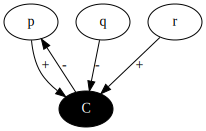

In [676]:
graphs['program1']

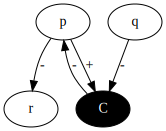

In [677]:
graphs['program2']

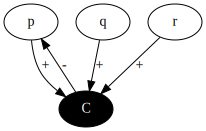

In [678]:
graphs['program3']

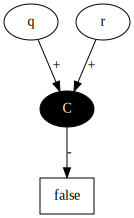

In [679]:
graphs['program4']

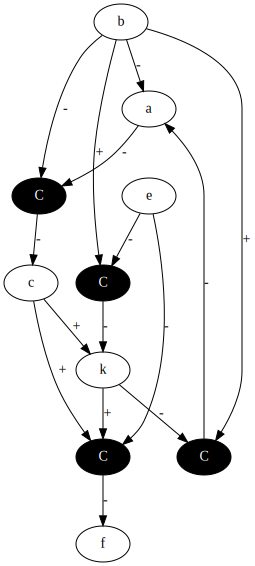

In [680]:
graphs['program5']